# Viral Data Analysis

Date: 2020.10.20

Author: © 2020 [Erik Schake](www.linkedin.com/in/erik-schake)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [How do highly libertarian vs. highly authoritarian governed countries perform with regard to "wave mitigation"?](#Q1)
1. [Can the temporal delay between an increase in Covid cases and deaths be quantified by utilizing Dynamic Time Warping?](#Q2)
1. [Trying to short-term forecast the amount of daily new Covid cases using k-nearest-neighbors retrieval and adaptation (case-based approach).](#Q3)

We additionally use data from:
* [FreedomHouse](https://freedomhouse.org/report/freedom-world)

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [173]:
# run this once to install the package
!pip install dtw-python

In [174]:
from datetime import date, timedelta
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
from dtw import *
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [175]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

11654465

Load the file to Pandas.

In [176]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

# restrict to 25/10 so that texts do make sense
# comment out for also including new values
df = df[df.date <= '2020-10-26']

Check the columns available.

In [177]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

### Explanation of additional data

FreedomHouse is an United States based NGO that promotes democracies around the globe. Each year they publish the "Freedom in the World" report in which they assign 210 countries and regions a score from 0 to 100 depicting the state of freedom in the respective country (0 being "not free" and 100 being "free"). Details can be found [here](https://freedomhouse.org/report/freedom-world). 

It is an aggregate score that is comprised of assessments of electoral process, political pluralism and freedom of expression, among others. By definition, free countries are those in which democracies are stable, while non-free countries are ruled by authoritarian regimes. More info on this definition can be found [here](https://freedomhouse.org/report/special-report/2017/breaking-down-democracy).



The data ("All Data, FIW 2013-2020" from [this site](https://freedomhouse.org/report/freedom-world)), which is only provided in xlsx format, was manually processed in the following way:

1. Every pre-2020 row was deleted
2. Row 0 was deleted
3. Columns "Country/Territory", "Region", "C/T", "Edition", "Status", "Total" were kept, all other columns deleted
4. Rows were renamed into "country", "region", "c/t", "edition", "status", "total"
5. Sheet 0 was deleted
6. The remainder was exported as csv

The resulting features are:
* _country_: The country or territory name
* _region_: Region of this country (mainly continents)
* _c/t_: Whether this entry describes a country or a territory
* _edition_: year of this entry (always 2020 here)
* _status_: Either F (Free), PF (Partly Free) or NF (Not Free)
* _total_: The freedom score from 0 (NF) to 100 (F)  





## Load the additional data

In [178]:
url = "freedomhouse.csv" 
df_freedom = pd.read_csv(url).rename(columns={'country': 'location', 'total': 'freedom'})
# keep only countries, no territories as they are not included int he owid dataset
df_freedom = df_freedom[df_freedom['c/t'] == 'c'].drop(['c/t'], axis=1)
df_freedom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 1 to 209
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  195 non-null    object
 1   region    195 non-null    object
 2   edition   195 non-null    int64 
 3   status    195 non-null    object
 4   freedom   195 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 9.1+ KB


Get top 5 and lowest 5 countries

In [179]:
df_freedom_sorted = df_freedom.sort_values('freedom', ascending=False).reset_index()[['location','freedom']]
df_freedom_sorted['rank'] = df_freedom_sorted['freedom'].rank(method='min', ascending=False).astype('int')

print('Top 5 most libertarian countries (it\'s a tie for first and fifth place):')
display(df_freedom_sorted.iloc[:7])
print('\nBottom 5 most authoritarian countries:')
display(df_freedom_sorted.iloc[-5:])

Top 5 most libertarian countries (it's a tie for first and fifth place):


,location,freedom,rank
0,Sweden,100,1
1,Norway,100,1
2,Finland,100,1
3,Netherlands,99,4
4,Luxembourg,98,5
5,Canada,98,5
6,Uruguay,98,5



Bottom 5 most authoritarian countries:


,location,freedom,rank
190,North Korea,3,191
191,Turkmenistan,2,192
192,Eritrea,2,192
193,South Sudan,2,192
194,Syria,0,195


In [180]:
print('Lithuania\'s rank and score:')
df_freedom_sorted[df_freedom_sorted['location']=='Lithuania']

Lithuania's rank and score:


,location,freedom,rank
37,Lithuania,91,36


One big problem is, that many of the most authoritarian countries do not provide sufficient or no data at all related to the pandemic. E.g. Turkmenistan and North Korea are free of the virus officially, which is hard to believe. It is known that at least in Turkmenistan, deaths have [increased significantly this year](https://thediplomat.com/2020/08/death-and-denial-in-turkmenistan/).

We therefore drop the last 10 entries from this list and then merge the data with the owid data.

In [181]:
df_freedom_sorted = df_freedom_sorted.iloc[:-10]
df = pd.merge(
    df, 
    df_freedom[['location','freedom']],
    on='location'
).fillna(0)

## Some constant parameters and util functions

In [182]:
figsize_big = (20,15)
figsize_normal = (15,10)
figsize_small = (10,6)

scaler = StandardScaler()

# get col of country from dataframe as numpy array
def col_of_country(df, country, col):
  return df[df.location == country][col].to_numpy()


# filter values from date to date
def filter_from_to(df, frm, to='2100-01-01'):
  tmp = df[df.date >= frm]
  return tmp[tmp.date <= to]

<a id='Q1'></a>
## 1. How do highly libertarian vs. highly authoritarian governed countries perform with regard to "wave mitigation"?

Let's first plot the curve of relative daily infections (7-day-moving avg) of the k most libertarian and authoritarian countries.

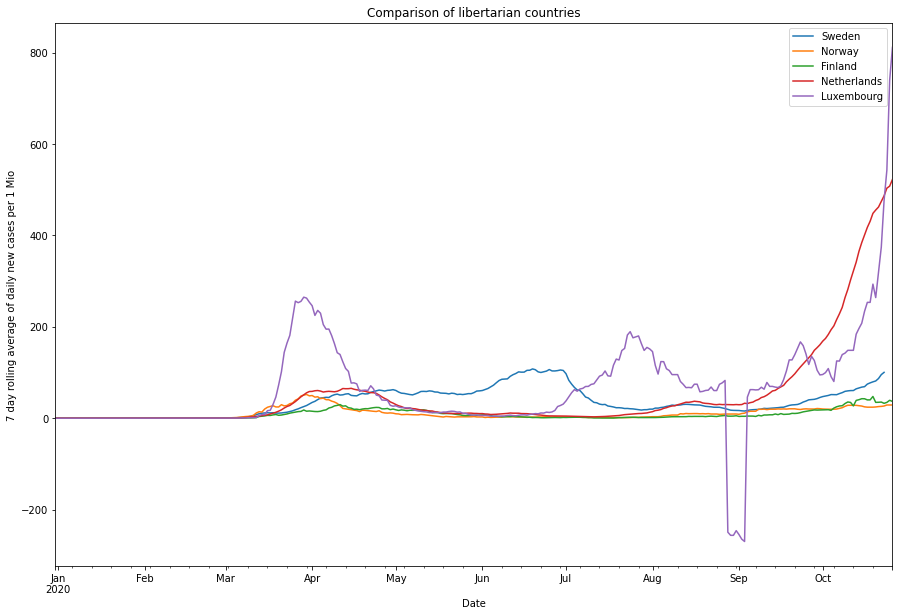

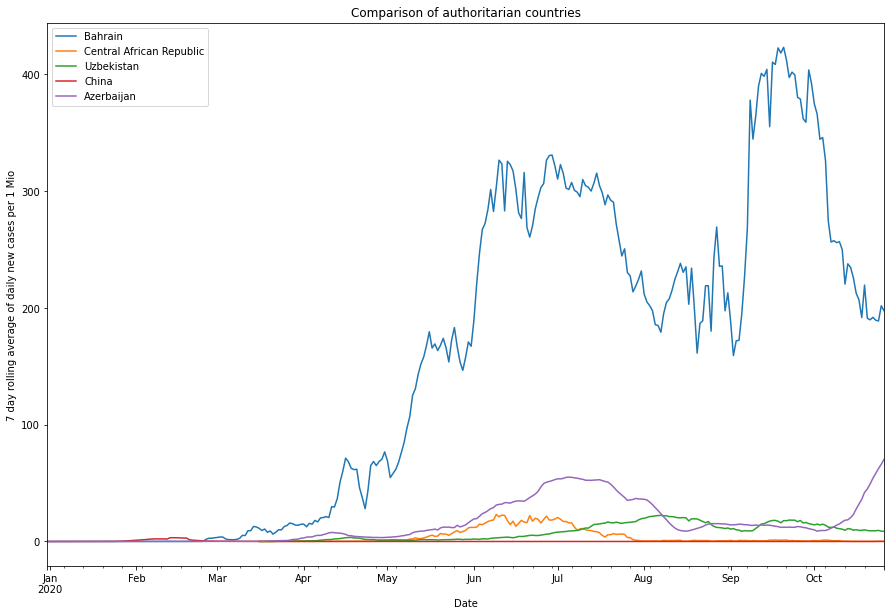

In [183]:
def plot_countries_smooth_new_cases(df, countries, title):
  fig, ax = plt.subplots()
  for c in countries:
    df[df.location == c].plot(x='date', y='new_cases_smoothed_per_million', ax=ax, figsize=figsize_normal)
  plt.legend(countries)
  plt.xlabel('Date')
  plt.ylabel('7 day rolling average of daily new cases per 1 Mio')
  plt.title(title)
  return ax

k = 5
countries_top = df_freedom_sorted.iloc[:k]['location'].to_numpy()
countries_bottom = df_freedom_sorted.iloc[-k:]['location'].to_numpy()

plot_countries_smooth_new_cases(df, countries_top, 'Comparison of libertarian countries')
plot_countries_smooth_new_cases(df, countries_bottom, 'Comparison of authoritarian countries')

Add 7-day incidence per million by country

In [184]:
col_new_cases = 'new_cases'
col_population = 'population'
col_incidence = 'incidence'
col_location = 'location'

df[col_incidence] = np.nan
# iterate over all countries
for c in df[col_location].unique():
  df_part_country = df[df.location == c]

  # calculate rolling window sum of size 7
  factor = 1000000 / df_part_country.iloc[0][col_population]
  df_part_country[col_incidence] = df_part_country[col_new_cases].rolling(7, min_periods=1).sum() * factor

  df[df.location == c] = df_part_country

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


We define a "wave" as the part of an outbreak in a country, during which the 7-day incidence rate is above 50 per 100,000 (or 500 per 1,000,000), i.e. the wave
* _starts_ when the incidence surpasses 50 for the first time and
* _ends_ when the incidence falls below 50 again

The amount of days between the start and end of a wave is the _duration of the wave_. We only include waves with a duration of more than 3 days, shorter spikes can also be artifacts.

Let's first plot the incidence rate developments of the same countries from above:

In [185]:
# define the parameters

threshold = 500
min_days = 4

(0.0, 6062.612624126164)

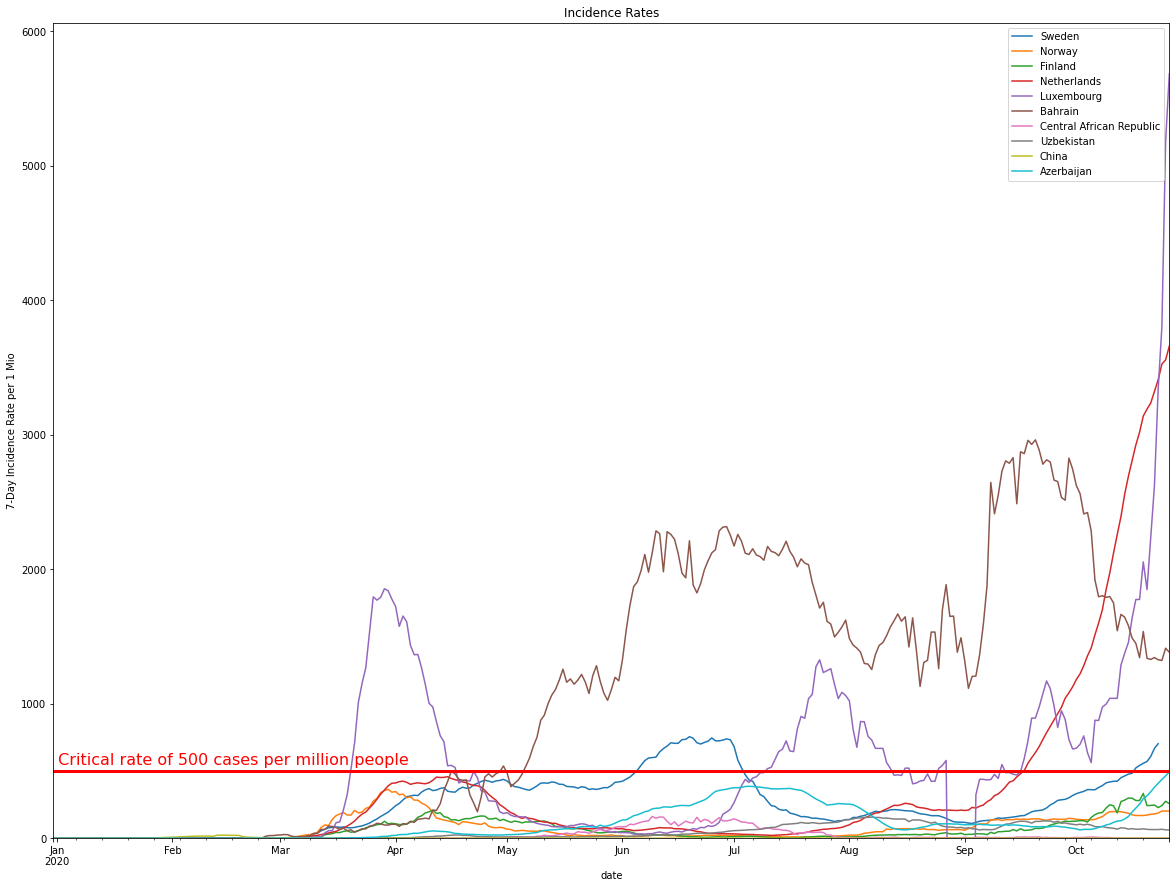

In [186]:
fig, ax = plt.subplots()

countries = np.concatenate((countries_top, countries_bottom))
for c in countries:
  df[df.location == c].plot(x='date', y='incidence', ax=ax, figsize=figsize_big)

plt.axhline(threshold, color='r', linestyle='-', linewidth=3)
plt.text(df['date'].min(), threshold+50, ' Critical rate of ' + str(threshold) + ' cases per million people', color='r', fontsize=16)

plt.ylabel('7-Day Incidence Rate per 1 Mio')
plt.title('Incidence Rates')
plt.legend(countries)
plt.ylim(0)

We can see that some countries stay below this mark while others are far above. Also notice that we can identify Luxemburg has 3 spikes above the threshold which qualify as waves according to our definition. Bahrain, Netherlands, and Sweden also have had at least one wave as of now (10/25). 

https://stackoverflow.com/questions/55160509/get-coherent-subsets-from-pandas-series#answer-55161325

In [187]:
# lets create a dataframe containing only country names, mean wave length and the freedom score
df1 = pd.DataFrame()

# calculate the wave lengths
df['wave'] = df['incidence'] > threshold
for c in df_freedom_sorted['location'].unique():
  df_c = df[df.location == c][['wave']]

  #identify waves
  df_c['wave_start'] = df_c['wave'].ne(df_c['wave'].shift())
  df_c['wave_start'][df_c['wave'] == False] = False
  df_c['wave_groups'] = df_c.wave_start.cumsum() * df_c['wave']

  waves = df_c.groupby('wave_groups')['wave'].count().iloc[1:]
  # remove waves of size 3 or less
  waves = waves[waves >= min_days]
  # if wave is currently ongoing, do not include (if its not the only one)
  if waves.index.size > 1 and waves.index.max() == df_c['wave_groups'].iloc[-1]:
    waves = waves.iloc[:-1]

  mean_len_wave = waves.mean()
  
  df1 = df1.append({
      'location': c,
      'freedom': df_freedom[df_freedom.location == c]['freedom'].item(),
      'mean_len_wave': mean_len_wave
  }, ignore_index=True)

df1['freedom'] = df1['freedom'].astype('int')
df1.fillna(0, inplace=True)

df1.describe()

,freedom,mean_len_wave
count,185.000000,185.000000
mean,61.983784,18.873604
std,27.895861,36.246252
min,10.000000,0.000000
25%,38.000000,0.000000
50%,65.000000,0.000000
75%,89.000000,22.000000
max,100.000000,178.000000


Text(0, 0.5, 'mean wave duration')

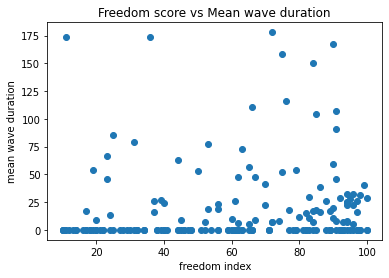

In [188]:
fig, ax = plt.subplots()
plt.scatter(df1['freedom'], df1['mean_len_wave'])
plt.title('Freedom score vs Mean wave duration')
plt.xlabel('freedom index')
plt.ylabel('mean wave duration')

Let's finally look at the correlation

In [189]:
df1.corr()

,freedom,mean_len_wave
freedom,1.000000,0.076895
mean_len_wave,0.076895,1.000000


No prominent correlation can be identified here. 

When we just look at countries, who had at least one wave however, we can see a slight negative correlation (-0.16995 on 10/25), depicting that democracies, in which every citizen bears responsibility towards his/her society, succeed better in their mitigation strategies.

In [190]:
df1[df1['mean_len_wave'] != 0].corr()

,freedom,mean_len_wave
freedom,1.000000,-0.166646
mean_len_wave,-0.166646,1.000000


<a id='Q2'></a>
## 2. Can the temporal delay between an increase in Covid cases and deaths be quantified by utilizing Dynamic Time Warping?

Let's look at Germany as an example and plot daily new cases and daily new deaths (both normalized per 1,000,000 and 7-day-smoothed):

(<matplotlib.axes._subplots.AxesSubplot at 0x7f792e5e9048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f792e5bb048>)

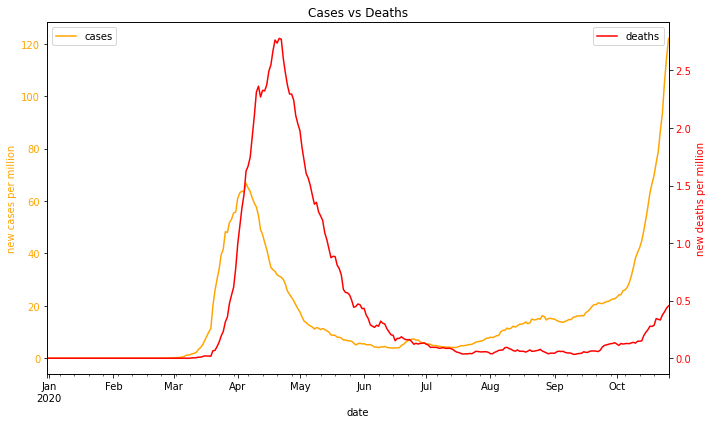

In [191]:
df_germany = df[df.location == 'Germany']

def plot_cases_vs_deaths(df, title='Cases vs Deaths', log=False):
  fig, ax1 = plt.subplots(figsize=figsize_small)
  df.plot(x='date', y='new_cases_smoothed_per_million', ax=ax1, color='orange')
  if log: ax1.set_yscale('symlog')
  ax1.set_xlabel('date')
  ax1.set_ylabel('new cases per million', color='orange')
  ax1.tick_params(axis='y', labelcolor='orange')
  #ax1.set_ylim(0)
  ax1.legend(['cases'], loc=2)

  ax2 = ax1.twinx()
  df.plot(x='date', y='new_deaths_smoothed_per_million', ax=ax2, color='r')
  if log: ax2.set_yscale('symlog')
  ax2.set_ylabel('new deaths per million', color='r')
  ax2.tick_params(axis='y', labelcolor='r')
  #ax2.set_ylim(0, df['new_cases_smoothed_per_million'].max()/23)
  ax2.legend(['deaths'], loc=1)

  plt.title(title)
  fig.tight_layout()

  return ax1, ax2

plot_cases_vs_deaths(df_germany)

Notice the different scales. We can however clearly see that the rate of deaths seems to be offset against the rate of new cases by a few days.

There are several ways in which this discovery can be utilized to quantify the temporal offset between cases and deaths.

The most simple way is to just shift the deaths to the left until the two curves align the best. We can then calculate the euclidean distance between the values at each day (day x of cases, day [x - shift_days] of deaths) and minimize this wrt to _shift\_days_.

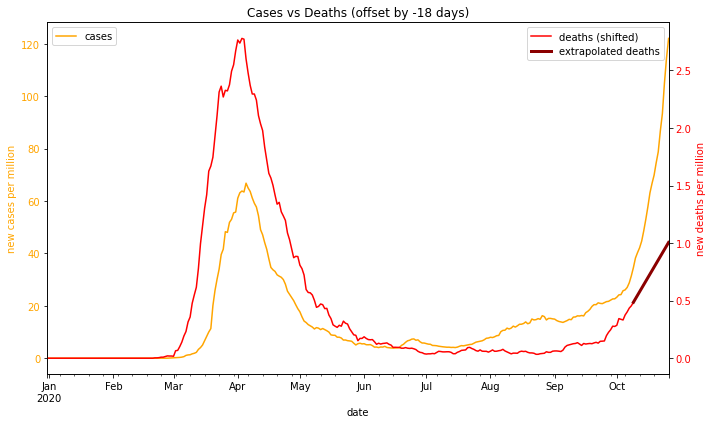

In [192]:
# brute force: try shifts from 1 day to max_shift days
max_shift = 30

cases_array = df_germany['new_cases_smoothed_per_million'].to_numpy()
deaths_array = df_germany['new_deaths_smoothed_per_million'].to_numpy()

# shift array by n entries to left
# keep length, fill last n entries with values based on exponential extrapolation (using linear regression in log space)
def shift(array, n, k = 5, method='exp'):

  ### exponential curve fitting ###
  if method == 'exp':
    x = np.array([x for x in range(k)]) + 1
    eps = .1e-20 #to prevent log(0)
    a, b = np.polyfit(x, np.log(array[-k:]+eps), deg=1)
    b = np.log(array[-1]) - a * (len(array) - 1 - n)
    x = np.array([x for x in range(len(array) - n, len(array))])
    return np.append(
        array[n:],
        np.exp(a * x + b)
    )

  ### linear curve fitting ###
  if method == 'lin':
    x = [x for x in range(k)]
    a = linregress(x, array[-k:])[0]
    b = array[-1] - a * (len(array) - 1 -n)
    x = np.array([x for x in range(len(array) - n, len(array))])
    return np.append(
        array[n:],
        (a * x + b)
    )

def distance(shift_days, cases, deaths, method='exp'):
  deaths_shifted = shift(deaths, shift_days, method=method)
  return np.linalg.norm(cases-deaths_shifted)

# find best offset by trying ranges of shifts on both linear and exponential curve fitting
best_offset_exp = np.argmin([distance(i, cases_array, deaths_array) for i in range(1,max_shift)]) + 1
best_offset_lin = np.argmin([distance(i, cases_array, deaths_array, method='lin') for i in range(1,max_shift)]) + 1
best_offset = np.min([best_offset_exp, best_offset_lin])
method_used = 'exp' if best_offset_exp <= best_offset_lin else 'lin'
df_to_plt = df_germany.copy()

# visualize on smoothed data
df_to_plt['new_deaths_smoothed_per_million'] = shift(df_germany['new_deaths_smoothed_per_million'].to_numpy(), best_offset, method=method_used)
ax1, ax2 = plot_cases_vs_deaths(df_to_plt, title=f'Cases vs Deaths (offset by -{best_offset} days)')
df_to_plt.iloc[-best_offset:].plot(x='date', y='new_deaths_smoothed_per_million', ax=ax2, color='darkred', linewidth=3)
ax2.legend(['deaths (shifted)', 'extrapolated deaths'], loc=1)

As of now (25/10), an offset of 20 days gives the best result based on this calculation. However, this approach is still pretty flawed:

* First and foremost, it assumes a constant offset during the entire outbreak, even though the offset appears to be smaller in the beginning (esp. during the first peak) than towards now.
* Secondly, the linear extrapolation used here (for Germany) is not always satisfactory, since during some parts of the pandemic the curve's growth was rather exponential. Even though I chose the method automatically based on which one produces the smallest distances, we'd still need to manually decide whether to use an exponential or linear extrapolation method for finding the alignment, since most of the variance is due to the non-extrapolated part.
* Finally, using extrapolation itself is not great, since it solely depends on the last _k_ data points of the curve. This parameter _k_ has to be tuned.

This results in this offset "not looking right", since the offset differs during different parts of the outbreak. We can manually find that 15 days offset seems to be satisfying for the first peak:

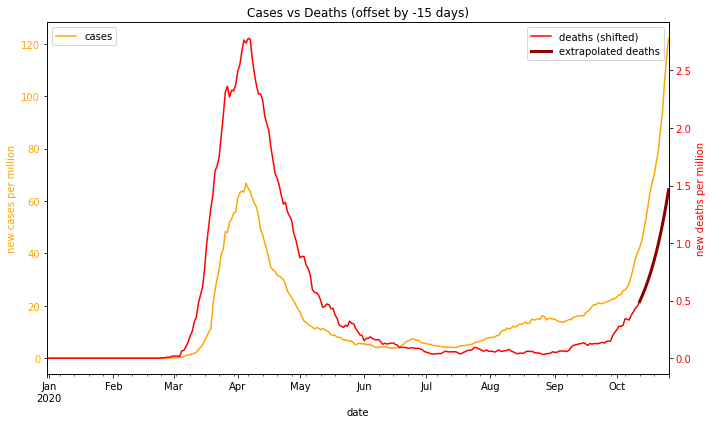

In [193]:
manual_offset = 15

df_to_plt['new_deaths_smoothed_per_million'] = shift(df_germany['new_deaths_smoothed_per_million'].to_numpy(), manual_offset)
ax1, ax2 = plot_cases_vs_deaths(df_to_plt, title=f'Cases vs Deaths (offset by -{manual_offset} days)')
df_to_plt.iloc[-manual_offset:].plot(x='date', y='new_deaths_smoothed_per_million', ax=ax2, color='darkred', linewidth=3)
ax2.legend(['deaths (shifted)', 'extrapolated deaths'], loc=1)

[Dynamic Time Warping](https://www.cs.unm.edu/~mueen/DTW.pdf) is "an algorithm for measuring similarity between two time series which may vary (i.e. warp) in timing".

It is therefore possible to align and compare cases and deaths even if the offset varies over time. The idea is, to align the two series and thereby find better estimates for how many days the death toll trails the cases. We can extract this information by looking at the end of the alignment and finding the mean offset of the last _k_ days.

Let's look at a quick example for Germany again:

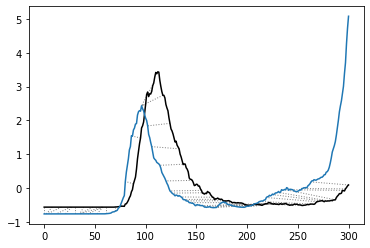

Last warp: 37


In [194]:
def future_window(i, j, query_size, reference_size, window_size):
  ratio = query_size/reference_size
  return j <= i/ratio and j >= (i/ratio) - window_size

alignment = dtw(
  (deaths_array - deaths_array.mean())/deaths_array.std(), 
  (cases_array - cases_array.mean())/cases_array.std(),
  window_type=future_window, 
  window_args={'window_size': 50},
  step_pattern='symmetric2',
  open_end=True, 
  #open_begin=True,
  keep_internals=True
)
ax = alignment.plot(type="twoway")
print('Last warp: ' + str(alignment.index1[-1]-alignment.index2[-1]))

The algorithm works, however:

* Due to the exponential growth, the differences grow quite rapidly despite the overall similar shape.
* The alignment during the first wave is accurate, but towards the end, the algorithm warps the death rate back by a full 37 days, which definitely isn't reasonable. Due to the exponential growth, the differences grow quite rapidly. The algorithm is therefore incentivised not to warp onto the big peak at the end (since the death rate hasn't risen that quickly YET)

We therefore try one last approach. Let's shift the deaths back by 14 days (look [here](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/928729/S0803_CO-CIN_-_Time_from_symptom_onset_until_death.pdf) for more on the median time to death) and then apply DTW with a limited warping window. This way, we assume that deaths trail cases by 14 days, with DTW telling us if it is less or more than this.

In [195]:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy/54628145
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

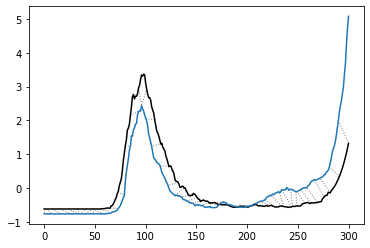

In [196]:
cases = df_germany['new_cases_smoothed_per_million'].to_numpy()
deaths_shifted = shift(df_germany['new_deaths_smoothed_per_million'].to_numpy(), 14)

deaths_shifted_standardized = (deaths_shifted - deaths_shifted.mean())/deaths_shifted.std()
cases_standardized = (cases - cases.mean())/cases.std()

alignment = dtw(
  deaths_shifted_standardized, 
  cases_standardized,
  window_type='sakoechiba', 
  window_args={'window_size': 10},
  step_pattern='symmetric2',
  open_end=True, 
  #open_begin=True,
  keep_internals=True
)
ax = alignment.plot(type="twoway")

Unfortunately, the library only provides limited plot customization possibilities. The x axis represents the days since 2019/12/31, the y axis shows the standardized scale of daily new deaths (black) and cases (blue).

Let's plot the "days-ahead" index:

Text(0.5, 1.0, 'deaths-cases-lag visualized')

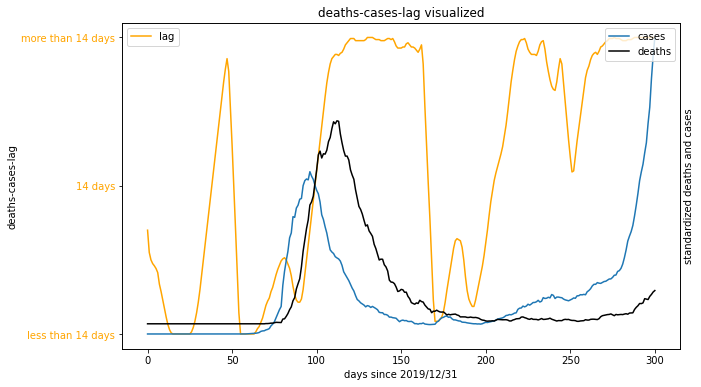

In [197]:
fig, ax1 = plt.subplots(figsize=figsize_small)

df_dvsc = pd.DataFrame({
  'deaths_idx': alignment.index1,
  'behind': alignment.index1-alignment.index2
}).groupby('deaths_idx').mean()
df_dvsc['behind'] = df_dvsc['behind'].rolling(7, min_periods=1).mean()
df_dvsc.plot(y='behind', ax=ax1, color='orange')

ax1.set_ylabel('deaths-cases-lag')
ax1.set_yticks([-10, 0, 10])
ax1.set_yticklabels(['less than 14 days', '14 days', 'more than 14 days'])
ax1.set_xlabel('days since 2019/12/31')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.legend(['lag'], loc=2)

ax2 = ax1.twinx()
ax2.plot(cases_standardized)
ax2.plot(deaths_standardized, color='black')

ax2.set_ylabel('standardized deaths and cases')
ax2.set_yticks([])
ax2.legend(['cases', 'deaths'], loc=1)

plt.title('deaths-cases-lag visualized')

Interpretation:
* High values of _lag_ depict that the death toll lags behind the cases for more than 14 days, i.e. a change in new cases will only become apparent in the amount of deaths more than 14 days later. Vice versa, low values depict that a change in the new cases show up faster in changes in the death rate
* Information gain is limited, however, we can see that the lag leans towards high values, i.e. the lag between changes in new cases and equivalent changes in new deaths is greater than 14 days most of the time.
* Most information can be gained by looking at the first wave: The lag starts at a low level, which means that the sudden increase in covid cases was quickly reflected in increased deaths. The lag then increases to a high level, which depicts that even after the daily new cases have decreased again, many infected people were still battling with their lives many more days after the cases were at a low level. Sadly, many of them did eventually not survive the infection.
* Before the start of the seconds wave, the dip of the lag was not as big as it was before the first wave. This seems to show that it takes longer for deaths to increase after cases started to increase again. This is probably due to the fact that during the beginning of the second wave, mostly yound people infected themselves.

**Overall Observations**

* Simply shifting the death curve x days to the left does not yield satisfying results as the lag before changes in new cases become apparent in the death toll does not stay constant throughout an outbreak.
* Applying DTW does give more insight into the connection of cases and deaths.
* Generally, the curve of new deaths follows the curve of new cases with a delay of more than 14 days
* Typically, increased cases will relatively fast show up in increased deaths, while decreased cases after a big peak will only later result in decreased death. The latter can be attributed to the fact that people still die from Covid-19 after battling for their lives for a long time.

<a id='Q3'></a>
## 3. Trying to short-term forecast the amount of daily new Covid cases using k-nearest-neighbors retrieval and adaptation (case-based approach).

Idea when trying to forecast a country: 
* Try to project the outbreak to countries' outbreaks, which are shaped in a similar way. Consider only those countries, where this mapping is done into the past, which means that they are "in front" in terms of their pandemic progress.
* Then find the last day's (of the to-be-predicted outbreak) projection date from the similar outbreak, extract the development of the ensuing days and project this development back onto the future of the to-be-predicted country 

E.g. when trying to forecast Germany, France seems to have a similarly shaped outbreak in the beginning, which DTW perfectly identifies. The outbreak in Germany can be interpreted to lag behind the one in France.

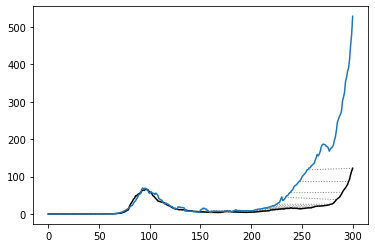

In [198]:
alignment = dtw(
  col_of_country(df, 'Germany', 'new_cases_smoothed_per_million'), 
  col_of_country(df, 'France', 'new_cases_smoothed_per_million'), 
  window_type='sakoechiba', 
  window_args={'window_size': 100},
  open_end=True, 
  keep_internals=True
)
ax = alignment.plot(type="twoway")

Approach:
1. Retrieve k nearest neighbors based on DTW distance measure, with a warping window of w, open_end=True. Restrict to only retrieve the countries, where a "backwards-warp" was found. I.e. the overall infection curves are similar, and one country is "ahead".
2. Of the k retrieved cases, let's say that for each retrieved case rc, the last day of the query was mapped onto the _i-th_ day of the retrieved case. Then extract the _i-th_ to _(i+f)-th_ days for each case rc. Then average the curves as a prediction.

### Step 1



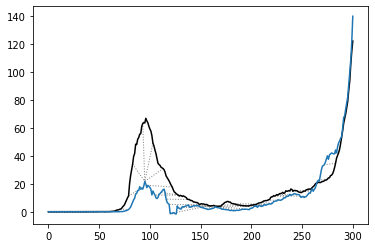

Distance between Germany and Lithuania: 2.119642262895178


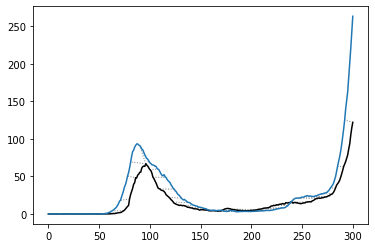

Distance between Germany and Italy: 0.9374579124579131


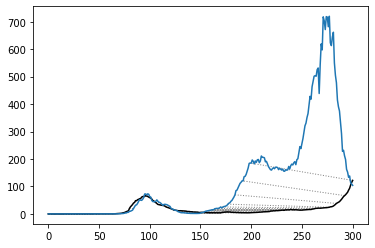

Distance between Germany and Israel: 5.142109561752987


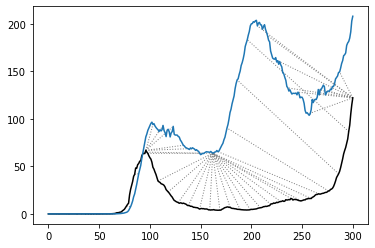

Distance between Germany and United States: 29.497178268251293


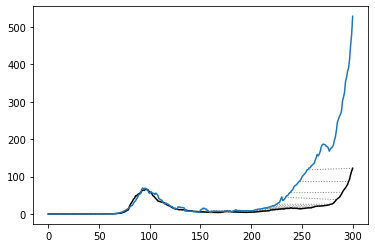

Distance between Germany and France: 0.715946140035906


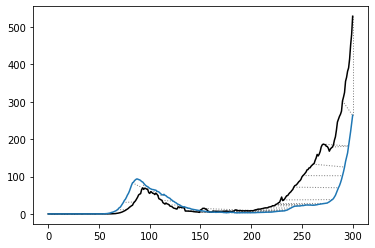

Distance between France and Italy: 1073741824


In [199]:
# get dtw distance
def dtw_back(query, case, window_size=100, plot=False, returnInternals=False):
  alignment = dtw(
    query, 
    case,
    window_type='sakoechiba', 
    window_args={'window_size': window_size},
    open_end=True, 
    keep_internals=True
  )
  if plot: alignment.plot(type='twoway')

  # if not mapped into past, assign big distance
  n = alignment.index2.shape[0]
  if alignment.index2[n-1] == len(case)-1:
    if returnInternals: 
      return 1073741824, alignment
    return 1073741824 # just a very big number representing 'infinite' distance (0 similarity)

  if returnInternals:
    return alignment.normalizedDistance, alignment
  return alignment.normalizedDistance

# some examples
col = 'new_cases_smoothed_per_million'
def dist(c1, c2):
  print(f'Distance between {c1} and {c2}: ' + str(dtw_back(
      col_of_country(df, c1, col),
      col_of_country(df, c2, col),
      plot=True
  )))

dist('Germany', 'Lithuania')
dist('Germany', 'Italy')
dist('Germany', 'Israel')
dist('Germany', 'United States')
dist('Germany', 'France')
dist('France', 'Italy')

The algorithm works pretty well. The mappings seem to be reasonable and so do the distance values (Remeber, small values represent high similarity). Also notice that France and Italy is assigned 'infinite distance/zero similarity', since France's outbreak is in front of Italy's. Therefore Italy cannot be used to forecast France's outbreak. For the same reason, the distance measure used is not symmetric.


array(['Netherlands', 'France', 'Austria', 'United Kingdom', 'Denmark'],
      dtype=object)

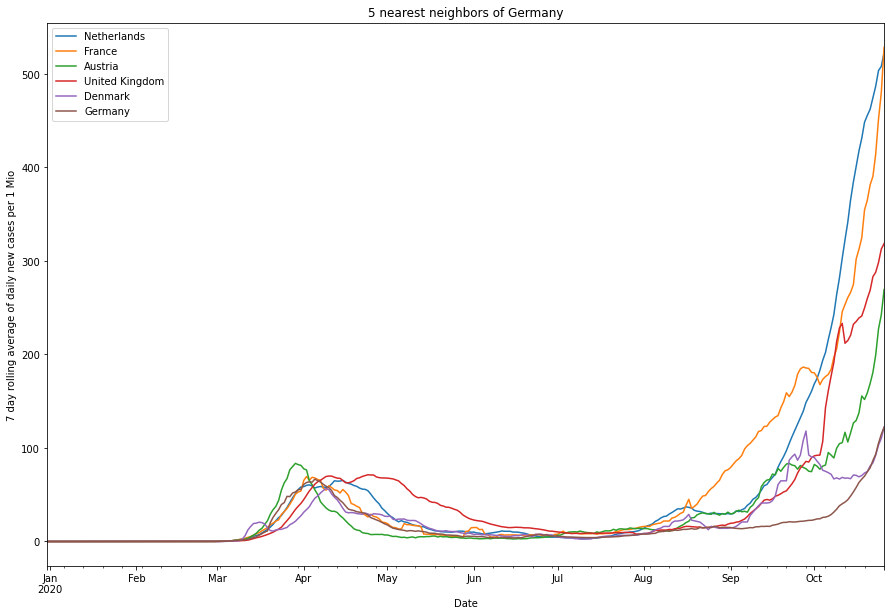

In [200]:
# init by extracting values from a dataframe into a numpy array
def init_retrieval(df,col='new_cases_smoothed_per_million'):
  country_names = df.location.unique()
  data = [df[df.location==c][col].to_numpy() for c in country_names]
  return data, country_names

# simple and slow linear retrieval of k nearest neighbors
def get_k_nearest_neighbors(k, query, data):
  tmp_dists = []
  tmp_alignments = []
  for idx, case in enumerate(data):
    # hacky: manually exclude indices where dtw does not work (for some reason)
    if idx == 36 or idx == 94 or idx == 139 or idx == 156 or idx == 170: 
      tmp_dists.append(23123123)
      tmp_alignments.append(None)
      continue
    dist, alignment = dtw_back(query, case, returnInternals=True)
    tmp_dists.append(dist)
    tmp_alignments.append(alignment)

  # return k nearest neighbors, their indices in original data array, and their assigned distances
  k_idc = np.argsort(tmp_dists)[:k]
  k_neighbors = [data[i] for i in k_idc]
  k_dists = [tmp_dists[i] for i in k_idc]
  k_alignments = [tmp_alignments[i] for i in k_idc]

  return k_neighbors, k_dists, k_alignments, k_idc

# find k nearest neighbors of Germany (takes several seconds)
k = 5
country = 'Germany'
data, names = init_retrieval(df)
query = col_of_country(df, country, 'new_cases_smoothed_per_million')
neighs, dists, aligns, idc = get_k_nearest_neighbors(k, query, data)

plot_countries_smooth_new_cases(df, np.append(names[idc], [country]), f'{k} nearest neighbors of {country}')
names[idc]

The retrieved cases look reasonable. Notice that all countries share a similar shaped outbreak, and Germany's shape can be projected onto parts of all of the others. It therefore lags behind, which is what we wanted.

Let's look at the US as comparison:

array(['Colombia', 'Brazil', 'Kuwait', 'Armenia', 'Bahamas'], dtype=object)

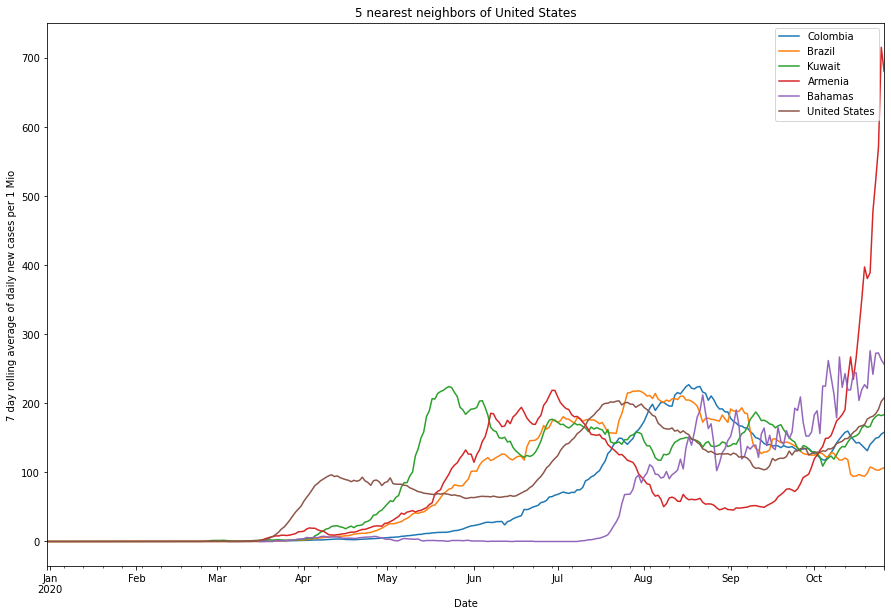

In [201]:
k = 5
country_us = 'United States'
data_us, names_us = init_retrieval(df)
query_us = col_of_country(df, country_us, 'new_cases_smoothed_per_million')
neighs_us, dists_us, aligns_us, idc_us = get_k_nearest_neighbors(k, query_us, data_us)

plot_countries_smooth_new_cases(df, np.append(names[idc_us], [country_us]), f'{k} nearest neighbors of {country_us}')
names[idc_us]

All these countries did not really mitigate their first wave and suffer from high case rates during the whole pandemic. The shape of the US's outbreak though is quite unique. But the retriever successfully identifies other hard hit countries.

### Step 2

We now extract the relevant data after the projection, average it, and project it back again.

In [202]:
# extract f data points after some index
def get_f_days_after_warp_end(f, data, warp_end_idx):
  return data[warp_end_idx : warp_end_idx + f]

# correct the start of predicted data to fit the endpoint of the actual data
def correct_start(data, startAt):
  out = []
  for d in data:
    diff = startAt - d[0]
    out.append(d + diff)
  return out

# data is array of arrays, remove every array that is smaller than the others
# quick and dirty approach
def remove_smaller_entries(data):
  max = 0;
  for d in data:
    if len(d) > max: max = len(d)
  
  out = []
  for d in data:
    if len(d) == max: out.append(d)

  return np.array(out)

# calculate the forecast as an average over the retrieved k-neighbors after-warp data
def get_average_f_days(f, query, data, alignments, window_size=100):
  f_days = []

  for idx, case in enumerate(data):
    alignment = alignments[idx]
    f_days.append(
        get_f_days_after_warp_end(
            f,
            case,
            alignment.index2[-1]
        )
    )

  f_days = correct_start(f_days, query[-1])

  return f_days, remove_smaller_entries(f_days).mean(axis=0)

get_average_f_days(5, query, neighs, aligns)

([array([122.026, 128.621, 135.324, 142.236, 151.79 ]),
  array([122.026, 122.97 , 127.371, 127.616, 131.895]),
  array([122.026, 111.557, 121.423, 131.876, 134.652]),
  array([122.026, 158.366, 176.356, 191.926, 206.771]),
  array([122.026,  96.351,  94.279,  93.688,  89.717])],
 array([122.026 , 123.573 , 130.9506, 137.4684, 142.965 ]))

Let's put all together

(array([122.026  , 126.577  , 133.3325 , 138.8665 , 145.04325, 151.91975,
        156.25275, 159.55   , 157.45275, 161.52975, 166.7025 , 171.014  ,
        176.0835 , 182.43025, 189.25025, 198.23475, 205.53725, 213.715  ,
        222.0905 , 226.5495 ]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f792fa1ada0>)

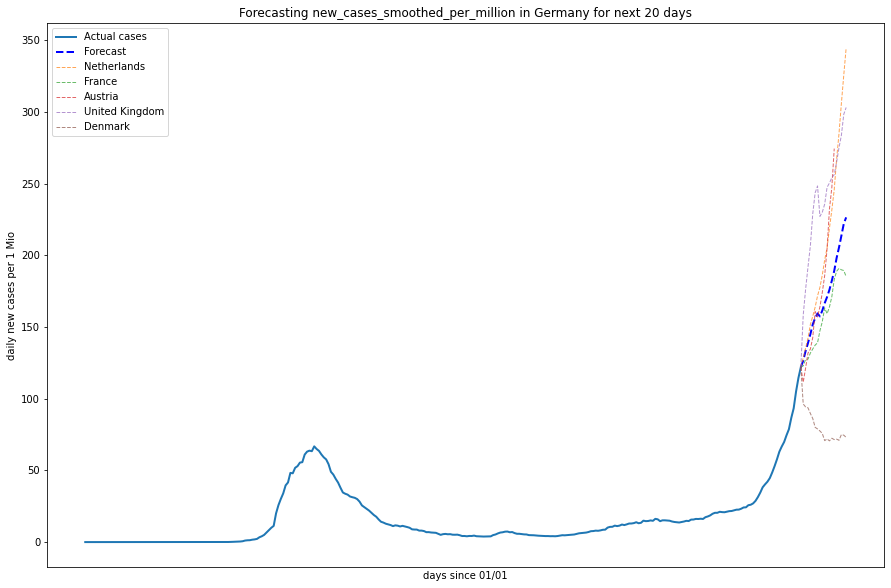

In [203]:
class Predictor:

  def __init__(self, df, col='new_cases_smoothed_per_million'):
    data, names = init_retrieval(df, col)
    self.data = data
    self.country_names = names
    self.df = df
    self.col = col

  # predict the next f days of a country by using its k nearest neighbors
  def predict_country(self, country, k, f, window_size=100, plot=False):
    query = col_of_country(self.df, country, self.col)
    k_neighbors, k_dists, k_aligns, k_idc = get_k_nearest_neighbors(k, query, self.data)
    raw_f, mean_f = get_average_f_days(f, query, k_neighbors, k_aligns, window_size)

    if plot:
      fig, ax = plt.subplots(figsize=figsize_normal)
      ax.plot(query, linewidth=2)
      x_pred = [x for x in range(len(query)-1,len(query)+len(mean_f)-1)]
      ax.plot(x_pred, mean_f, linestyle='--', color='blue', linewidth=2)
      for case in raw_f:
        ax.plot([x for x in range(len(query)-1,len(query)+len(case)-1)], case, linestyle='--', linewidth=1, alpha=0.7)

      ax.set_xlabel('days since 01/01')
      ax.set_xticks([])
      ax.set_ylabel('daily new cases per 1 Mio')
      ax.legend(['Actual cases', 'Forecast'] + self.country_names[k_idc].tolist())

      plt.title(f'Forecasting {self.col} in {country} for next {f} days')

      return mean_f, ax
    
    return mean_f

# takes a few seconds to run
# Change the country name to get predictions for other countries
pred = Predictor(df)
pred.predict_country('Germany', k=5, f=20, plot=True)

Final Remarks:
* Weights could be introduced, so that similarity towards the end of the considered period are more important when finding neighbors.
* Besides the plain shape of the outbreak, we could also include other factors in the similarity search, like governments' responses or age of the population. 
* The shown examples show that the prediction can be pretty accurate during the rising phase of a wave. The same will probably hold for the decline after a peak. However, verification still needs to be done if this method is also suitable in accurately predicting the turning point of a wave, or its beginning.
* The model's hyperparameters (k, f, window_size) need to be tuned
* In general, verification still needs to be done for this method

(array([139.746     , 163.394     , 170.47133333, 178.72066667,
        189.25466667, 204.30533333, 226.07533333, 246.46766667,
        253.48833333, 270.15966667, 282.01      , 303.51566667,
        330.48433333, 345.767     , 369.12833333]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f792eeada58>)

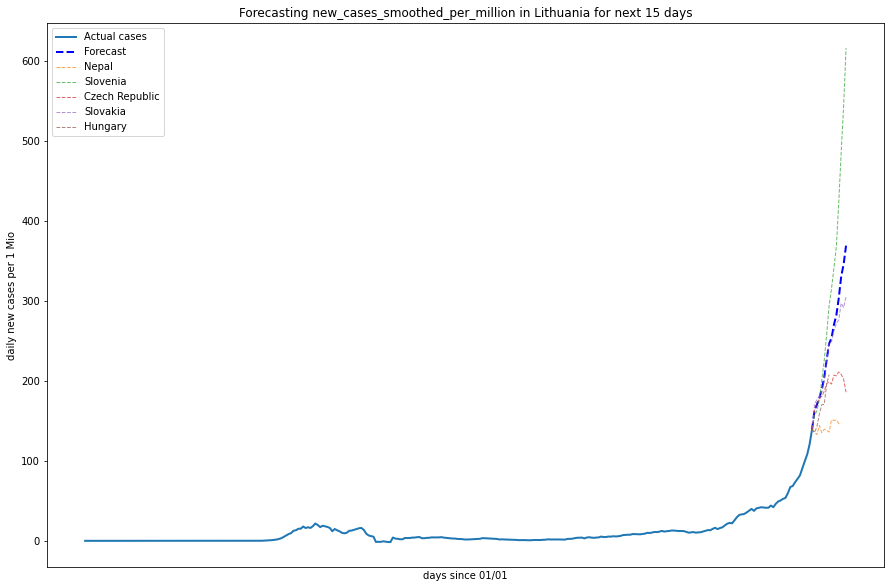

In [217]:
# predict other countries:
country = 'Lithuania'
pred = Predictor(df)
pred.predict_country(country, k=5, f=15, plot=True)